In [3]:
#Как итог берем 1.5% подъема против 0.5% падения
#для дальнейшего рассмотрения еще интересны 2% к 0.5%
#И все таки это большие размахи, можно попробовать на меньшию прибыть расчитывать, что она будет срабатывать в первый день чаще,
#потому что в целом таких сигналов много а ракмках одного дня
#при построении моделей можно будет поиграться

### TODO:
* рассмотреть короткий таргет при анализе (за него надо платить)
* 0.1 % комиссия (купил + продал)
* 1.5% подъема против 0.5% падения
* распределение времени по дростижепию этих таргетов
* TR
* можно попробовать рассмотреть более больлште изменения проценто, например, 10% к 5%

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [5]:
dfs = []

stocks = [
          'GAZP',
          'SBER',
          'LKOH',
          'MGNT',
          'NVTK',
          'SNGS',
          'GMKN',
          'ROSN',
          'NLMK',
          'TATN',
          'MTSS',
          'ALRS',  
          'YDEX',
          'CHMF',
          
          'MAGN',
          'TCSG',
          'OZON',
          'RUAL'  
         ]
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1min/{stock}.pkl")
    dfs += [df.copy()]
    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'


df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df.shape

100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 36.23it/s]


(7847346, 7)

In [6]:
df

,time,open,close,volume,low,high,ticker
0,2022-10-03 10:00:00,219.000,219.930,87793.0,218.000,220.250,GAZP
1,2022-10-03 10:01:00,219.800,220.800,61549.0,219.700,220.550,GAZP
2,2022-10-03 10:02:00,220.240,219.340,52640.0,219.200,220.380,GAZP
3,2022-10-03 10:03:00,219.170,218.960,61506.0,217.700,219.400,GAZP
4,2022-10-03 10:04:00,218.820,218.300,51464.0,217.760,218.960,GAZP
...,...,...,...,...,...,...,...
7847341,2024-11-19 23:45:00,38.485,38.455,1020.0,38.455,38.490,RUAL
7847342,2024-11-19 23:46:00,38.490,38.510,1102.0,38.490,38.510,RUAL
7847343,2024-11-19 23:47:00,38.500,38.520,665.0,38.475,38.520,RUAL
7847344,2024-11-19 23:48:00,38.520,38.520,781.0,38.520,38.530,RUAL


In [7]:
indx = random.sample(range(df.shape[0]), 1_000_000)
#idx

In [8]:
(pd.Timestamp('23:59') - pd.Timestamp('10:00')) / pd.Timedelta(minutes=1) + 1

840.0

In [9]:
def get_target(df_all, ind, val_first, val_second, days_to_wait):
    #цель - достичь val_second, не достигнув val_first

    points_in_day = 840 # торговая сессия
    points_to_wait = days_to_wait * points_in_day
    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]
    
    if val_first < val_second:  
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else:
        mask_val_first = np.array(df['close'] > val_first)
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):
        return 'DNF', -1
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        return 'WIN', delta_time
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        return 'LOSE', delta_time

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            return 'LOSE', delta_time
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            return 'WIN', delta_time


def get_df_target(df, indx, percent_first=None, percent_second=None, days_to_wait=None):
    times = []
    results = []
    delta_times = []
    closes = []
    tickers = []
    
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time = get_target(df, ind, val_first, val_second, days_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times
                             })
    return df_result    

# 1. Риск менеджмент потери=0.5%, выигрыш=1.1%, ожидание 7 дней

In [11]:
df_result = get_df_target(df, indx, percent_first=0.995, percent_second=1.011, days_to_wait=7)

100%|███████████████████████████████| 1000000/1000000 [07:17<00:00, 2283.15it/s]


In [12]:
df_result

,ind,time,close,result,ticker,delta_time
0,2481582,2024-02-28 21:48:00,29.15,WIN,SNGS,0 days 12:19:00
1,1356549,2022-11-02 19:52:00,5250.00,LOSE,MGNT,0 days 03:02:00
2,64863,2023-01-24 11:16:00,160.10,LOSE,GAZP,0 days 00:55:00
3,4197516,2024-01-05 18:03:00,722.80,LOSE,TATN,3 days 15:57:00
4,7344603,2024-07-26 13:34:00,3981.00,LOSE,OZON,0 days 00:01:00
...,...,...,...,...,...,...
999995,7574186,2023-07-20 23:18:00,41.49,LOSE,RUAL,0 days 11:07:00
999996,4423231,2022-12-21 22:57:00,224.40,WIN,MTSS,0 days 11:58:00
999997,3383947,2024-05-02 12:46:00,580.80,LOSE,ROSN,6 days 21:15:00
999998,1744489,2024-10-02 21:43:00,5028.50,WIN,MGNT,0 days 12:27:00


In [13]:
df_result['result'].value_counts()

result
LOSE    619879
WIN     379346
DNF        775
Name: count, dtype: int64

In [15]:
0.621*0.994 + 0.379*1.01

1.000064

In [16]:
#по дню выполнения посмотреть

In [18]:
df_result['delta_time_days'] = None
mask = df_result['result'] != 'DNF'
df_result.loc[mask, 'delta_time_days'] = np.ceil(df_result.loc[mask, 'delta_time'] / pd.Timedelta(hours=24))
df_result.loc[~mask, 'delta_time_days'] = 8

<Axes: xlabel='delta_time_days'>

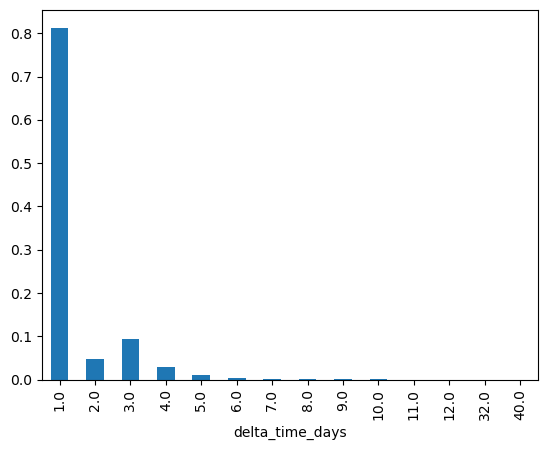

In [19]:
#распределение по длительности
df_result['delta_time_days'].value_counts(normalize=True).sort_index().plot.bar()

In [20]:
#TR по дням ожидания

In [21]:
df_result['target'] = (df_result['result'] == 'WIN').astype(int)

<Axes: xlabel='delta_time_days'>

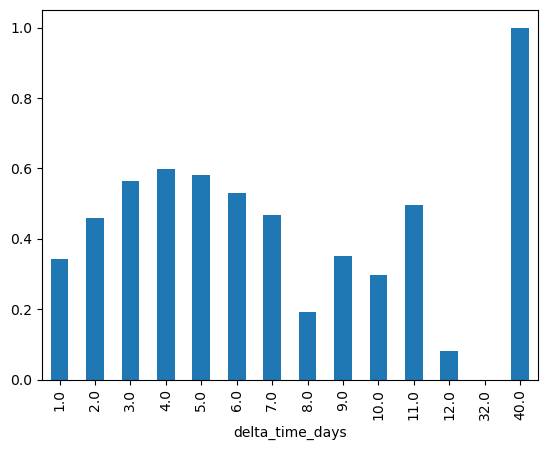

In [22]:
df_result.groupby('delta_time_days').target.mean().sort_index().plot.bar()

In [23]:
#TR во времени

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_33212/2486965488.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_result.groupby(pd.Grouper(key='time', freq='M')).target.mean().sort_index().plot.bar()


<Axes: xlabel='time'>

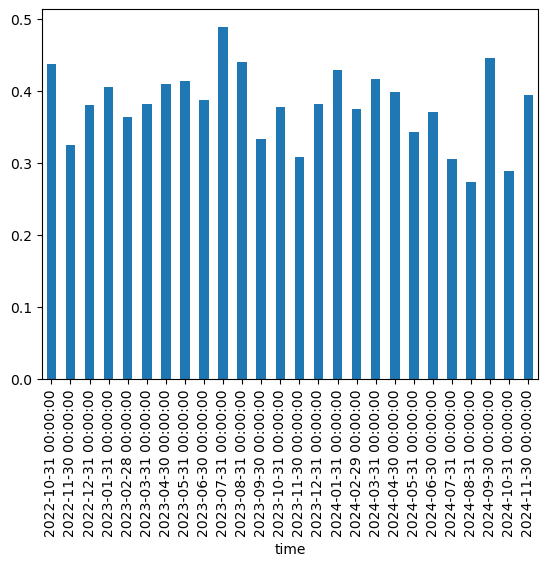

In [24]:
df_result.groupby(pd.Grouper(key='time', freq='M')).target.mean().sort_index().plot.bar()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_33212/539452958.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()


<Axes: xlabel='time'>

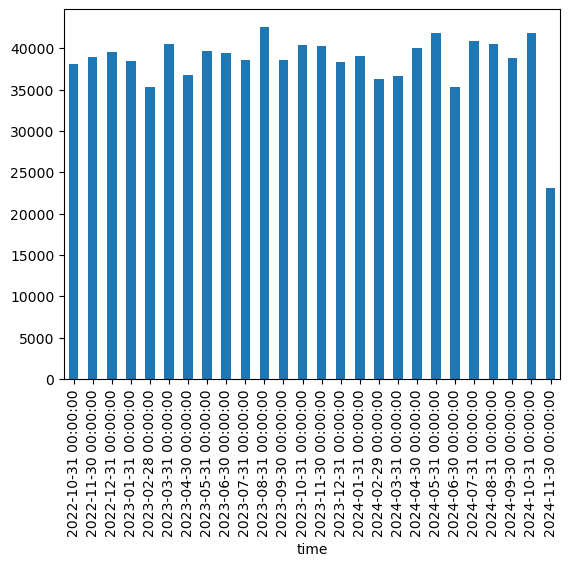

In [25]:
#перепроверка, кол-во точек в каждом месяце
df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()

<Axes: xlabel='time'>

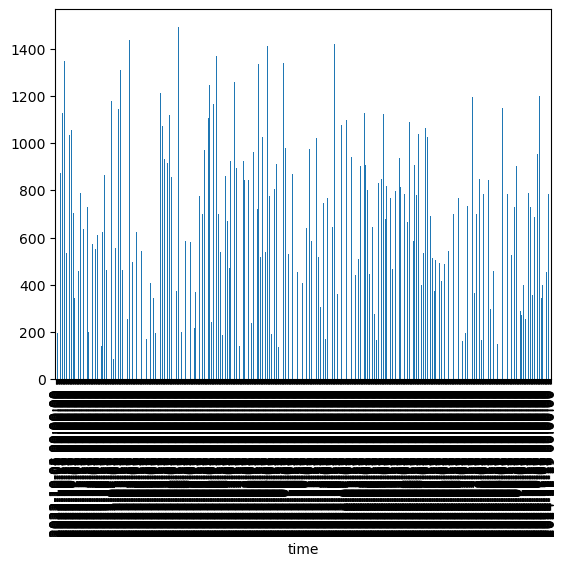

In [26]:
#распределение по дням
df_result.groupby(pd.Grouper(key='time', freq='D')).target.sum().sort_index().plot.bar()

In [37]:
df_result.groupby(pd.Grouper(key='time', freq='D')).target.sum().quantile([0.001] + np.arange(0.1, 1, 0.1).tolist() + [0.99])

0.001       0.00
0.100       0.00
0.200       0.00
0.300     145.40
0.400     317.20
0.500     450.00
0.600     601.40
0.700     753.60
0.800     877.80
0.900    1101.60
0.990    1407.54
Name: target, dtype: float64

In [ ]:
#выходные

In [40]:
2/7, (df_result.groupby(pd.Grouper(key='time', freq='D')).target.sum() == 0).mean()

(0.2857142857142857, 0.2862644415917843)

<Axes: xlabel='ticker'>

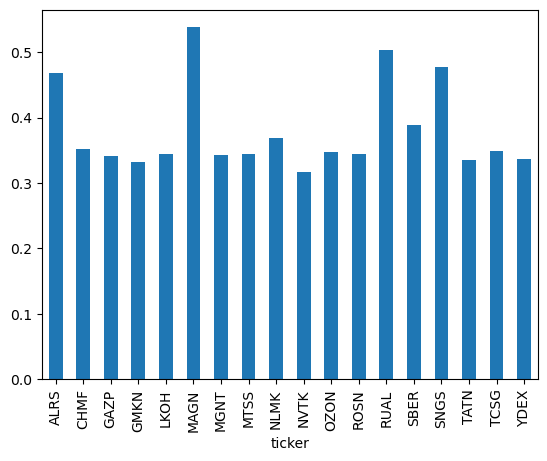

In [43]:
#по акциям
df_result.groupby('ticker').target.mean().sort_index().plot.bar()

<Axes: xlabel='ticker'>

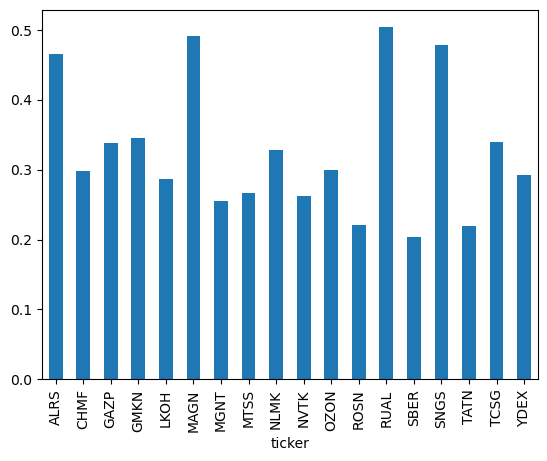

In [44]:
# по компаниям за два последних месяца
mask = df_result['time'] > datetime.datetime(2024, 10, 1)
df_result.loc[mask, :].groupby('ticker').target.mean().sort_index().plot.bar()

# 2. Риск менеджмент потери=0.5%, выигрыш=1.5%, ожидание 7 дней

In [45]:
df_result = get_df_target(df, indx, percent_first=0.995, percent_second=1.015, days_to_wait=7)

100%|███████████████████████████████| 1000000/1000000 [07:19<00:00, 2275.09it/s]


In [46]:
#по дню выполнения посмотреть

In [47]:
df_result['result'].value_counts()

result
LOSE    685077
WIN     313305
DNF       1618
Name: count, dtype: int64

In [85]:
0.6887*0.994 + 0.313*1.014

1.0019498

In [49]:
df_result['delta_time_days'] = None
mask = df_result['result'] != 'DNF'
df_result.loc[mask, 'delta_time_days'] = np.ceil(df_result.loc[mask, 'delta_time'] / pd.Timedelta(hours=24))
df_result.loc[~mask, 'delta_time_days'] = 8

<Axes: xlabel='delta_time_days'>

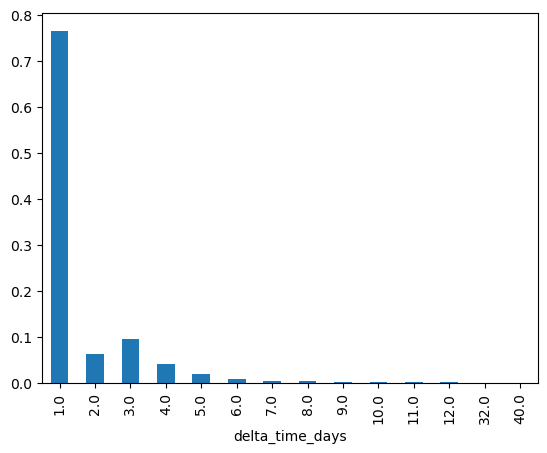

In [50]:
#распределение по длительности
df_result['delta_time_days'].value_counts(normalize=True).sort_index().plot.bar()

In [51]:
#TR по дням ожидания

In [52]:
df_result['target'] = (df_result['result'] == 'WIN').astype(int)

<Axes: xlabel='delta_time_days'>

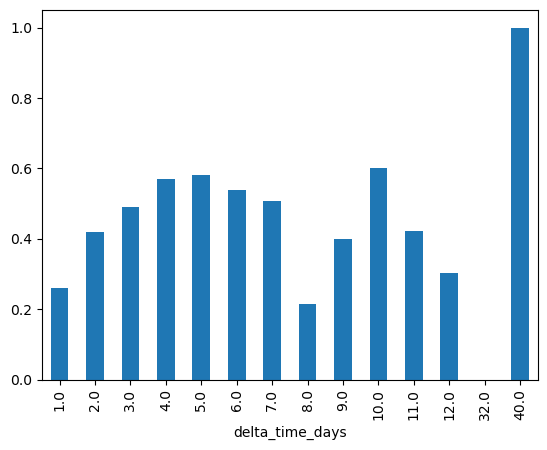

In [53]:
df_result.groupby('delta_time_days').target.mean().sort_index().plot.bar()

In [54]:
#TR во времени

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_33212/2486965488.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_result.groupby(pd.Grouper(key='time', freq='M')).target.mean().sort_index().plot.bar()


<Axes: xlabel='time'>

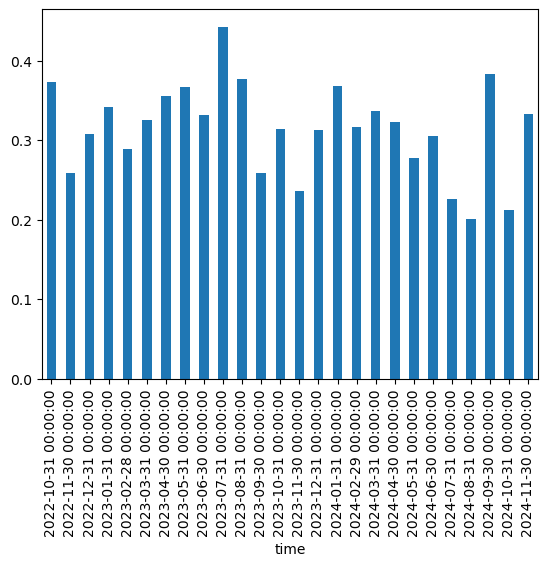

In [55]:
df_result.groupby(pd.Grouper(key='time', freq='M')).target.mean().sort_index().plot.bar()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_33212/539452958.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()


<Axes: xlabel='time'>

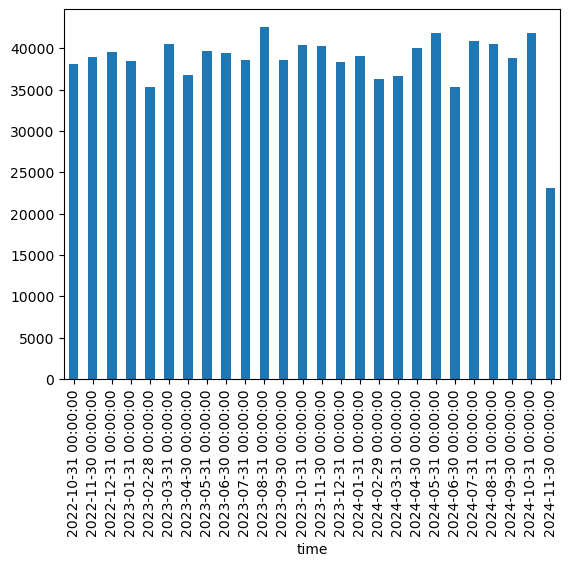

In [56]:
#перепроверка, кол-во точек в каждом месяце
df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()

<Axes: xlabel='time'>

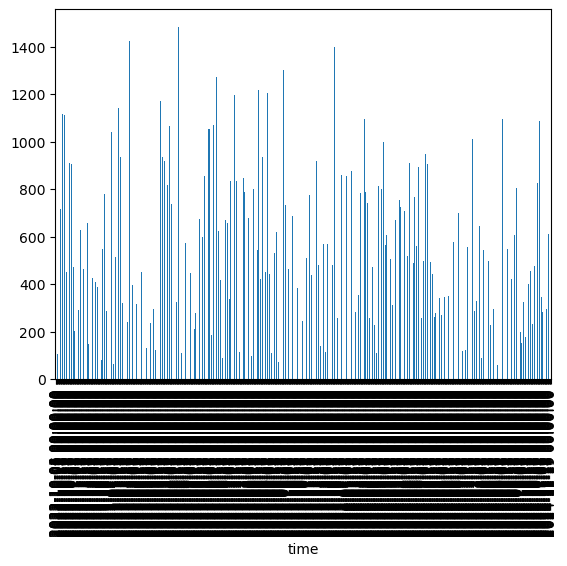

In [57]:
#распределение по дням
df_result.groupby(pd.Grouper(key='time', freq='D')).target.sum().sort_index().plot.bar()

<Axes: xlabel='ticker'>

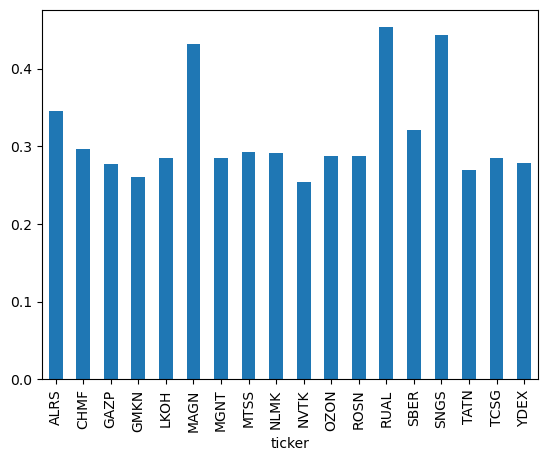

In [58]:
#по акциям
df_result.groupby('ticker').target.mean().sort_index().plot.bar()

<Axes: xlabel='ticker'>

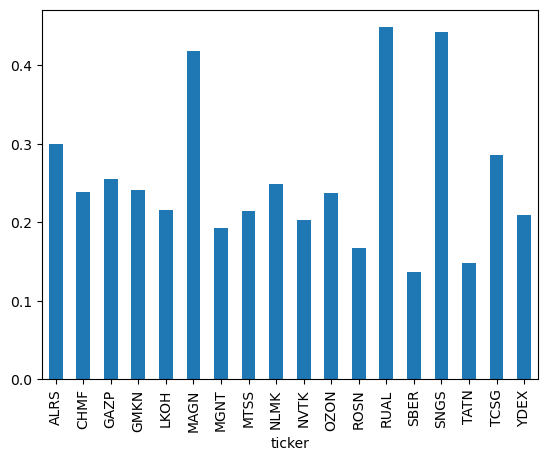

In [60]:
# по компаниям за два последних месяца
mask = df_result['time'] > datetime.datetime(2024, 10, 1)
df_result.loc[mask, :].groupby('ticker').target.mean().sort_index().plot.bar()

# 3. Some other experements

In [61]:
df_result = get_df_target(df, indx[:50_000], percent_first=0.995, percent_second=1.013, days_to_wait=7)
df_result['result'].value_counts(normalize=True)

100%|███████████████████████████████████| 50000/50000 [00:21<00:00, 2280.72it/s]


result
LOSE    0.65570
WIN     0.34322
DNF     0.00108
Name: proportion, dtype: float64

In [86]:
0.657*0.994 + 0.343*1.012

1.0001740000000001

In [63]:
df_result = get_df_target(df, indx[:50_000], percent_first=0.995, percent_second=1.015, days_to_wait=7)
df_result['result'].value_counts(normalize=True)

100%|███████████████████████████████████| 50000/50000 [00:22<00:00, 2228.88it/s]


result
LOSE    0.68594
WIN     0.31232
DNF     0.00174
Name: proportion, dtype: float64

In [87]:
0.688*0.994 + 0.312*1.014

1.0002399999999998

In [65]:
df_result = get_df_target(df, indx[:50_000], percent_first=0.996, percent_second=1.016, days_to_wait=7)
df_result['result'].value_counts(normalize=True)

100%|███████████████████████████████████| 50000/50000 [00:21<00:00, 2283.58it/s]


result
LOSE    0.73882
WIN     0.26000
DNF     0.00118
Name: proportion, dtype: float64

In [88]:
0.74*0.995 + 0.26*1.015

1.0002

In [67]:
df_result = get_df_target(df, indx[:50_000], percent_first=0.996, percent_second=1.008, days_to_wait=7)
df_result['result'].value_counts(normalize=True)

100%|███████████████████████████████████| 50000/50000 [00:22<00:00, 2195.31it/s]


result
LOSE    0.6023
WIN     0.3973
DNF     0.0004
Name: proportion, dtype: float64

In [68]:
df_result = get_df_target(df, indx[:50_000], percent_first=0.99, percent_second=1.01, days_to_wait=2)
df_result['result'].value_counts(normalize=True)

100%|███████████████████████████████████| 50000/50000 [00:13<00:00, 3682.46it/s]


result
WIN     0.52124
LOSE    0.41508
DNF     0.06368
Name: proportion, dtype: float64

In [69]:
df_result = get_df_target(df, indx[:50_000], percent_first=0.95, percent_second=1.10, days_to_wait=30)
df_result['result'].value_counts(normalize=True)

100%|████████████████████████████████████| 50000/50000 [00:58<00:00, 854.33it/s]


result
LOSE    0.49564
WIN     0.29702
DNF     0.20734
Name: proportion, dtype: float64

In [ ]:
#переберем
#неплохо бы пересчитать с учетом включения вечерних торгов
l_percent_first = []
l_percent_second = []
l_results = []
a = tqdm()

for percent_first in np.arange(0.001, 0.021, 0.001):
    for percent_second in np.arange(0.001, 0.021, 0.001):
        df_result = get_df_target(df, indx[:100_000], percent_first=1-percent_first, percent_second=1+percent_second, days_to_wait=1)

        percent_win = df_result['result'].value_counts(normalize=True).loc['WIN']
        percent_lose = 1 - percent_win

        result = (1-percent_first-0.001)*percent_lose + (1+percent_second-0.001)*percent_win

        l_percent_first += [1-percent_first]
        l_percent_second += [1+percent_second]
        l_results += [result]

df_percent = pd.DataFrame({'percent_first' : l_percent_first,
                          'percent_second' : l_percent_second,
                          'E_game': l_results
                          })

In [95]:
df_percent.sort_values(by='E_game', ascending=False).iloc[:50]

,percent_first,percent_second,E_game
119,0.994,1.020,1.000643
139,0.993,1.020,1.000631
179,0.991,1.020,1.000619
159,0.992,1.020,1.000618
118,0.994,1.019,1.000612
99,0.995,1.020,1.000603
138,0.993,1.019,1.000598
158,0.992,1.019,1.000592
117,0.994,1.018,1.000585
178,0.991,1.019,1.000584


In [99]:
mask = df_percent.percent_first == 0.995
df_percent[mask].sort_values(by='E_game', ascending=False)

,percent_first,percent_second,E_game
99,0.995,1.020,1.000603
98,0.995,1.019,1.000570
97,0.995,1.018,1.000545
96,0.995,1.017,1.000505
95,0.995,1.016,1.000462
94,0.995,1.015,1.000425
93,0.995,1.014,1.000370
92,0.995,1.013,1.000307
91,0.995,1.012,1.000231
90,0.995,1.011,1.000137


# 4. Риск менеджмент потери=0.5%, выигрыш=2%, ожидание 7 дней
### (просто для интереса)

In [70]:
df_result = get_df_target(df, indx, percent_first=0.995, percent_second=1.02, days_to_wait=7)

100%|███████████████████████████████| 1000000/1000000 [07:19<00:00, 2274.19it/s]


In [71]:
#по дню выполнения посмотреть

In [72]:
df_result['result'].value_counts()

result
LOSE    740422
WIN     256140
DNF       3438
Name: count, dtype: int64

In [90]:
0.744*0.994 + 0.256*1.019

1.0004

In [74]:
df_result['delta_time_days'] = None
mask = df_result['result'] != 'DNF'
df_result.loc[mask, 'delta_time_days'] = np.ceil(df_result.loc[mask, 'delta_time'] / pd.Timedelta(hours=24))
df_result.loc[~mask, 'delta_time_days'] = 8

<Axes: xlabel='delta_time_days'>

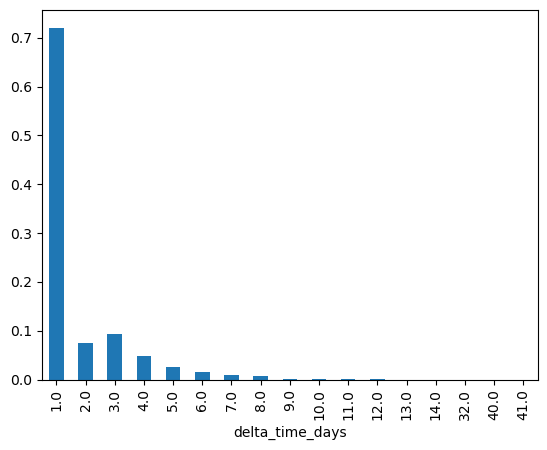

In [75]:
#распределение по длительности
df_result['delta_time_days'].value_counts(normalize=True).sort_index().plot.bar()

In [76]:
#TR по дням ожидания

In [77]:
df_result['target'] = (df_result['result'] == 'WIN').astype(int)

<Axes: xlabel='delta_time_days'>

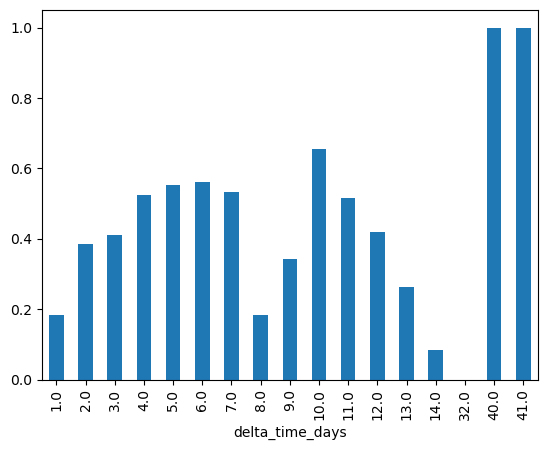

In [78]:
df_result.groupby('delta_time_days').target.mean().sort_index().plot.bar()

In [79]:
#TR во времени

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_33212/2486965488.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_result.groupby(pd.Grouper(key='time', freq='M')).target.mean().sort_index().plot.bar()


<Axes: xlabel='time'>

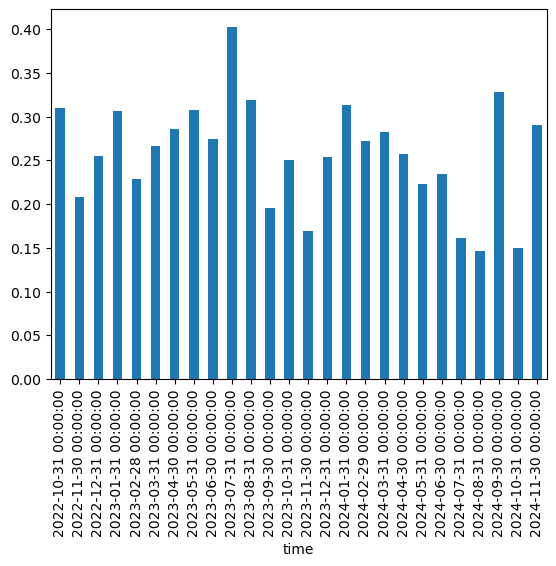

In [80]:
df_result.groupby(pd.Grouper(key='time', freq='M')).target.mean().sort_index().plot.bar()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_33212/539452958.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()


<Axes: xlabel='time'>

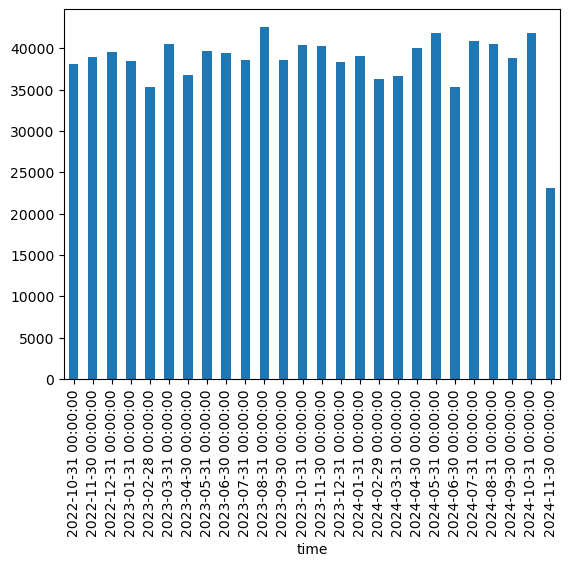

In [81]:
#перепроверка, кол-во точек в каждом месяце
df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()

<Axes: xlabel='time'>

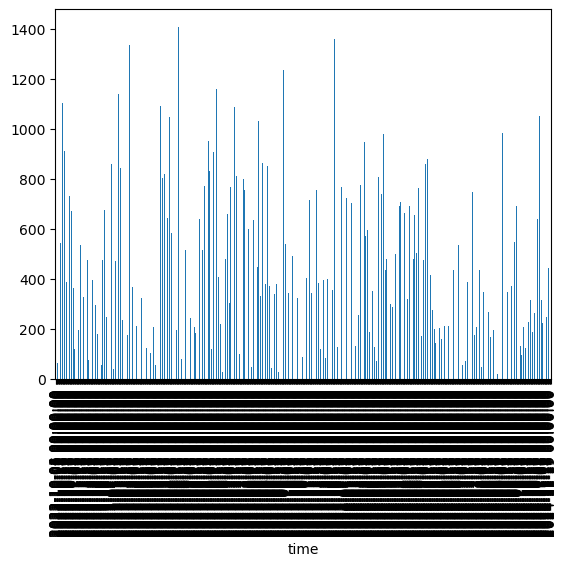

In [82]:
#распределение по дням
df_result.groupby(pd.Grouper(key='time', freq='D')).target.sum().sort_index().plot.bar()

<Axes: xlabel='ticker'>

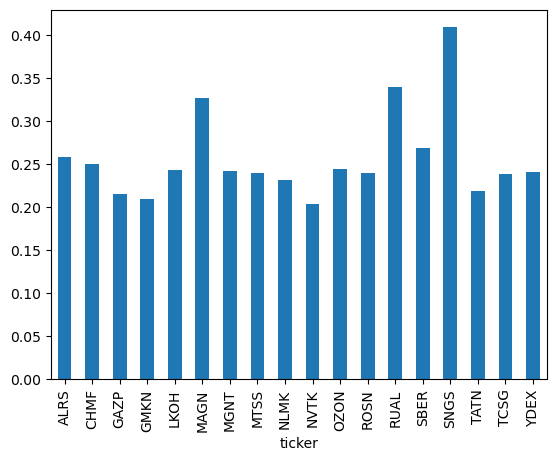

In [83]:
#по акциям
df_result.groupby('ticker').target.mean().sort_index().plot.bar()

<Axes: xlabel='ticker'>

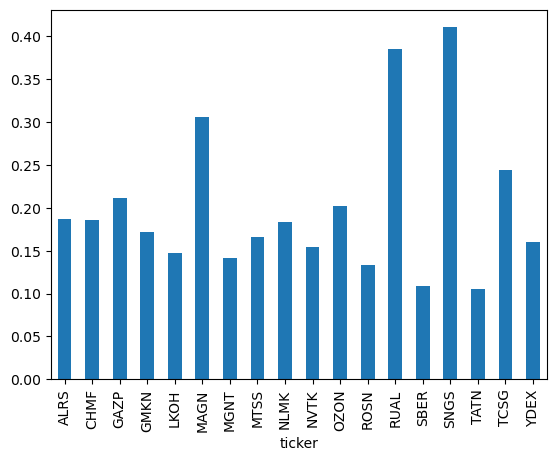

In [84]:
# по компаниям за два последних месяца
mask = df_result['time'] > datetime.datetime(2024, 10, 1)
df_result.loc[mask, :].groupby('ticker').target.mean().sort_index().plot.bar()

# 5.x Короткие таргеты (мб они более стабильные?)

In [ ]:
#Стабильности не сильно добавила, но было принято решение перейтина таргет с вызреванием 4 часа (все таки мы работаем со скальпингом)

In [12]:
def get_target(df_all, ind, val_first, val_second, hours_to_wait):
    #цель - достичь val_second, не достигнув val_first

    points_in_hour = 60 # hour
    points_to_wait = hours_to_wait * points_in_hour
    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]
    
    if val_first < val_second:  
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else:
        mask_val_first = np.array(df['close'] > val_first)
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):
        return 'DNF', -1
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        return 'WIN', delta_time
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        return 'LOSE', delta_time

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            return 'LOSE', delta_time
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            return 'WIN', delta_time


def get_df_target(df, indx, percent_first=None, percent_second=None, hours_to_wait=None):
    times = []
    results = []
    delta_times = []
    closes = []
    tickers = []
    
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time = get_target(df, ind, val_first, val_second, hours_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times
                             })
    return df_result    

# 5.1 Риск менеджмент потери=0.5%, выигрыш=1.5%, ожидание 1 day

In [13]:
df_result = get_df_target(df, indx, percent_first=0.995, percent_second=1.015, hours_to_wait=24)

100%|████████████████████████████████████████████████████████████| 1000000/1000000 [2:03:59<00:00, 134.41it/s]


In [27]:
#по дню выполнения посмотреть

In [14]:
df_result['result'].value_counts()

result
LOSE    654620
WIN     284192
DNF      61188
Name: count, dtype: int64

In [28]:
df_result['delta_time_days'] = None
mask = df_result['result'] != 'DNF'
df_result.loc[mask, 'delta_time_days'] = np.ceil(df_result.loc[mask, 'delta_time'] / pd.Timedelta(hours=24))
df_result.loc[~mask, 'delta_time_days'] = 8

<Axes: xlabel='delta_time_days'>

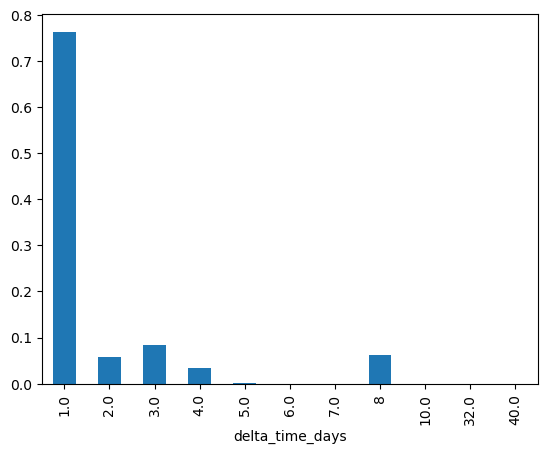

In [29]:
#распределение по длительности
df_result['delta_time_days'].value_counts(normalize=True).sort_index().plot.bar()

In [30]:
#TR по дням ожидания

In [31]:
df_result['target'] = (df_result['result'] == 'WIN').astype(int)

<Axes: xlabel='delta_time_days'>

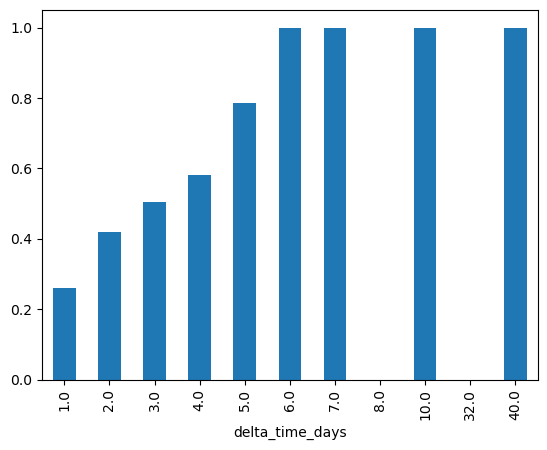

In [32]:
df_result.groupby('delta_time_days').target.mean().sort_index().plot.bar()

In [33]:
#TR во времени

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_41472/2486965488.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_result.groupby(pd.Grouper(key='time', freq='M')).target.mean().sort_index().plot.bar()


<Axes: xlabel='time'>

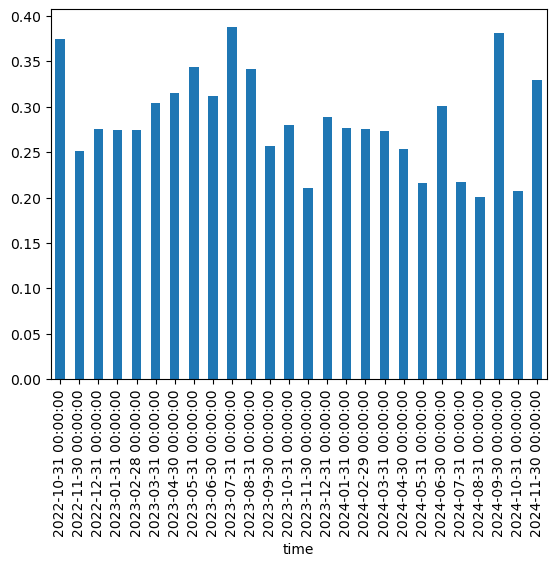

In [34]:
df_result.groupby(pd.Grouper(key='time', freq='M')).target.mean().sort_index().plot.bar()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_41472/539452958.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()


<Axes: xlabel='time'>

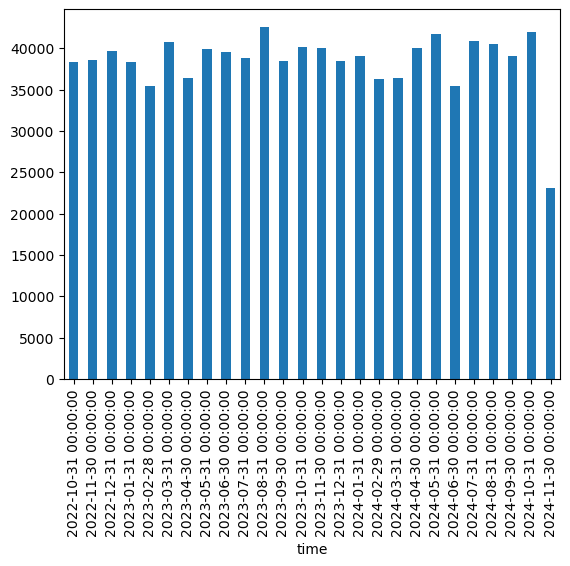

In [35]:
#перепроверка, кол-во точек в каждом месяце
df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()

<Axes: xlabel='time'>

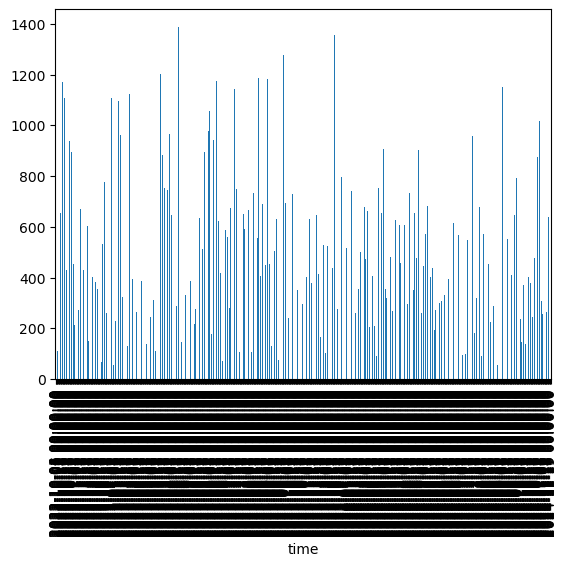

In [36]:
#распределение по дням
df_result.groupby(pd.Grouper(key='time', freq='D')).target.sum().sort_index().plot.bar()

<Axes: xlabel='ticker'>

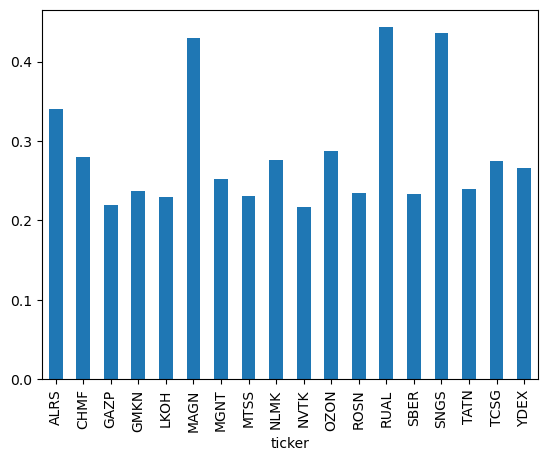

In [37]:
#по акциям
df_result.groupby('ticker').target.mean().sort_index().plot.bar()

<Axes: xlabel='ticker'>

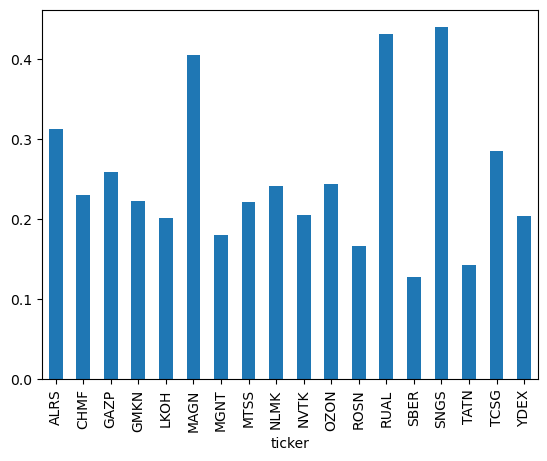

In [38]:
# по компаниям за два последних месяца
mask = df_result['time'] > datetime.datetime(2024, 10, 1)
df_result.loc[mask, :].groupby('ticker').target.mean().sort_index().plot.bar()

# 5.2 Риск менеджмент потери=0.5%, выигрыш=1.5%, ожидание 8 hour

In [111]:
df_result = get_df_target(df, indx, percent_first=0.995, percent_second=1.015, hours_to_wait=8)

100%|█████████████████████████████████████████████████████████████| 1000000/1000000 [03:35<00:00, 4634.77it/s]


In [112]:
#по дню выполнения посмотреть

In [113]:
df_result['result'].value_counts()

result
LOSE    539995
DNF     269912
WIN     190093
Name: count, dtype: int64

In [127]:
df_result['delta_time_days'] = None
mask = df_result['result'] != 'DNF'
df_result.loc[mask, 'delta_time_days'] = np.ceil(df_result.loc[mask, 'delta_time'] / pd.Timedelta(hours=1))
df_result.loc[~mask, 'delta_time_days'] = -10

<Axes: xlabel='delta_time_days'>

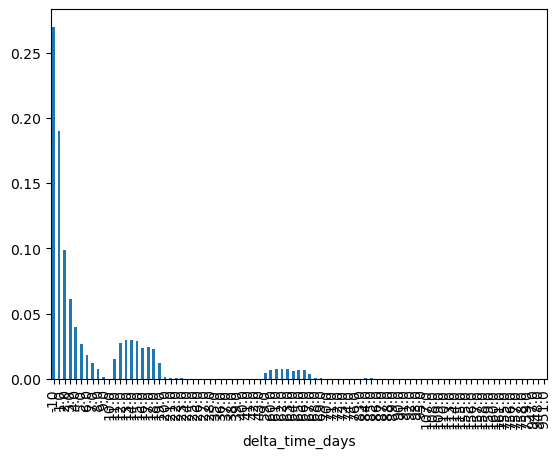

In [128]:
#распределение по длительности
df_result['delta_time_days'].value_counts(normalize=True).sort_index().plot.bar()

In [116]:
#TR по часам ожидания

In [117]:
df_result['target'] = (df_result['result'] == 'WIN').astype(int)

<Axes: xlabel='delta_time_days'>

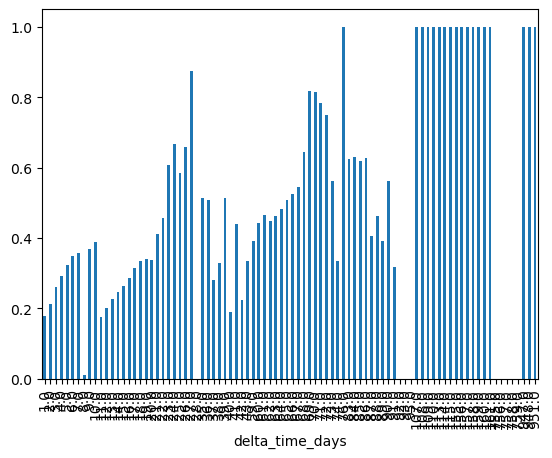

In [118]:
df_result.groupby('delta_time_days').target.mean().sort_index().plot.bar()

In [119]:
#TR во времени

<Axes: xlabel='time'>

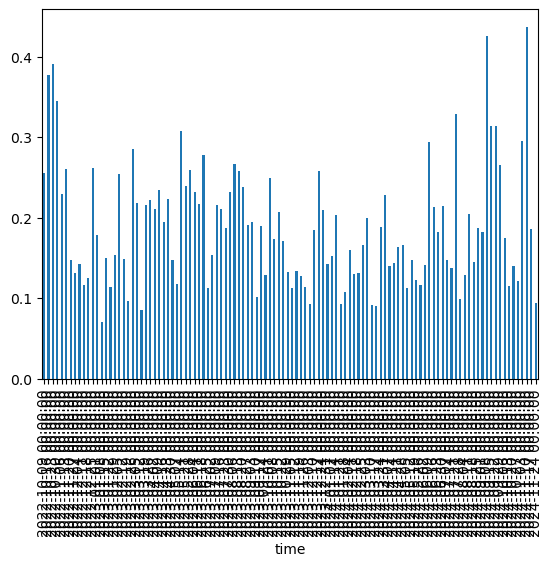

In [120]:
df_result.groupby(pd.Grouper(key='time', freq='W')).target.mean().sort_index().plot.bar()

<Axes: xlabel='time'>

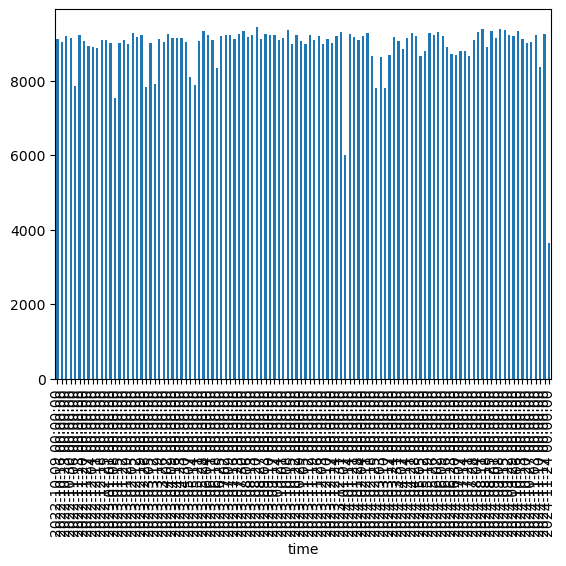

In [121]:
#перепроверка, кол-во точек в каждом месяце
df_result.groupby(pd.Grouper(key='time', freq='W')).target.count().sort_index().plot.bar()

<Axes: xlabel='time'>

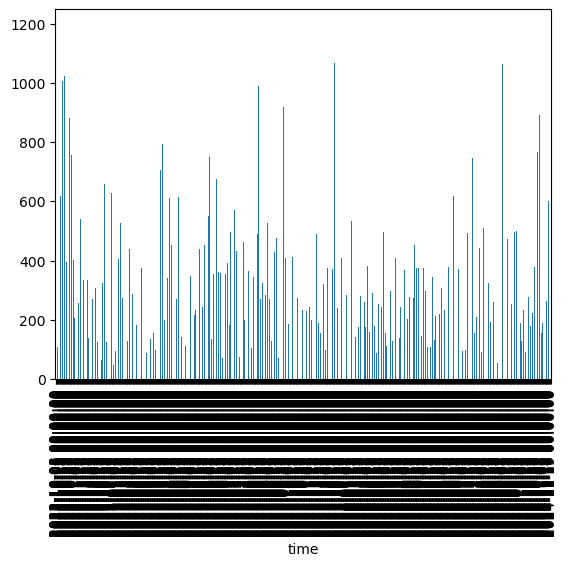

In [122]:
#распределение по дням
df_result.groupby(pd.Grouper(key='time', freq='D')).target.sum().sort_index().plot.bar()

<Axes: xlabel='ticker'>

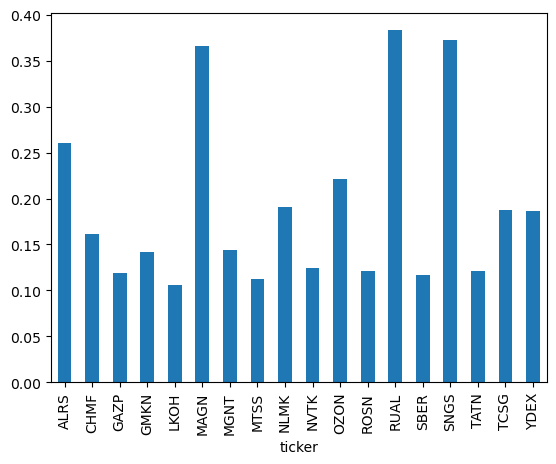

In [123]:
#по акциям
df_result.groupby('ticker').target.mean().sort_index().plot.bar()

<Axes: xlabel='ticker'>

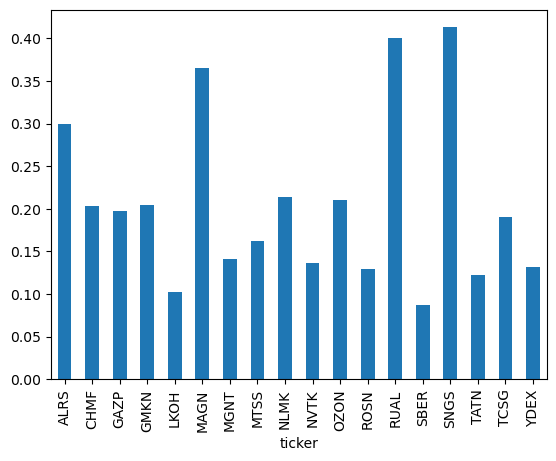

In [124]:
# по компаниям за два последних месяца
mask = df_result['time'] > datetime.datetime(2024, 10, 1)
df_result.loc[mask, :].groupby('ticker').target.mean().sort_index().plot.bar()

# 5.3 Риск менеджмент потери=0.5%, выигрыш=1.5%, ожидание 4 hour

In [129]:
df_result = get_df_target(df, indx, percent_first=0.995, percent_second=1.015, hours_to_wait=4)

100%|█████████████████████████████████████████████████████████████| 1000000/1000000 [03:23<00:00, 4909.49it/s]


In [130]:
#по дню выполнения посмотреть

In [131]:
df_result['result'].value_counts()

result
DNF     464036
LOSE    414009
WIN     121955
Name: count, dtype: int64

In [132]:
df_result['delta_time_days'] = None
mask = df_result['result'] != 'DNF'
df_result.loc[mask, 'delta_time_days'] = np.ceil(df_result.loc[mask, 'delta_time'] / pd.Timedelta(hours=1))
df_result.loc[~mask, 'delta_time_days'] = -1

<Axes: xlabel='delta_time_days'>

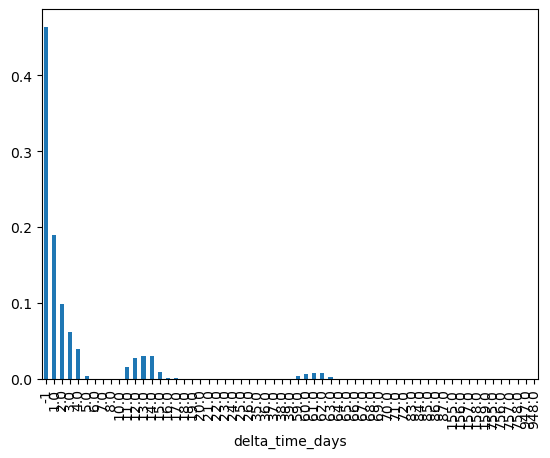

In [133]:
#распределение по длительности
df_result['delta_time_days'].value_counts(normalize=True).sort_index().plot.bar()

In [88]:
#TR по часам ожидания

In [135]:
df_result['target'] = (df_result['result'] == 'WIN').astype(int)

<Axes: xlabel='delta_time_days'>

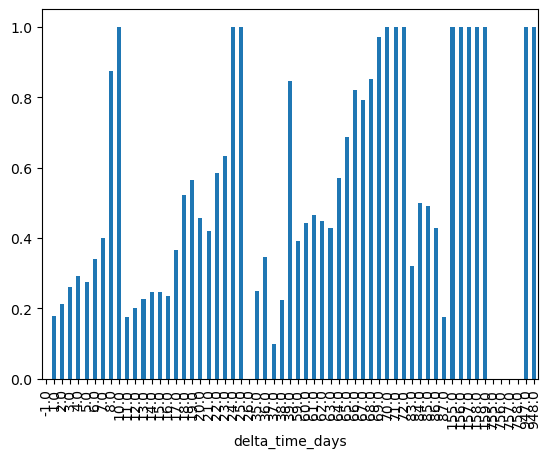

In [136]:
df_result.groupby('delta_time_days').target.mean().sort_index().plot.bar()

In [137]:
#TR во времени

<Axes: xlabel='time'>

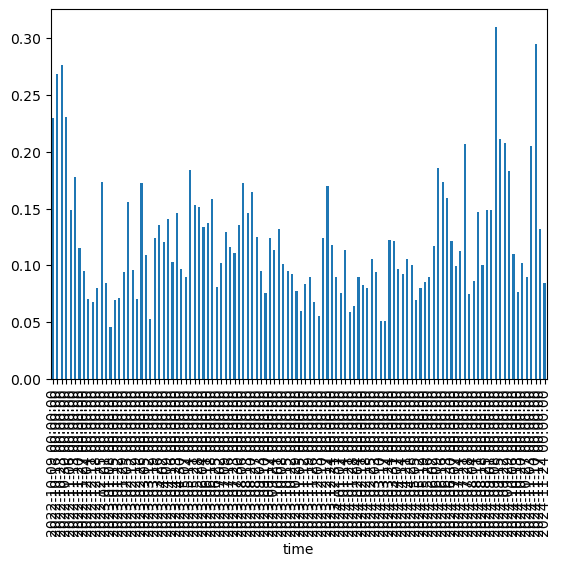

In [138]:
df_result.groupby(pd.Grouper(key='time', freq='W')).target.mean().sort_index().plot.bar()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_41472/2486965488.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_result.groupby(pd.Grouper(key='time', freq='M')).target.mean().sort_index().plot.bar()


<Axes: xlabel='time'>

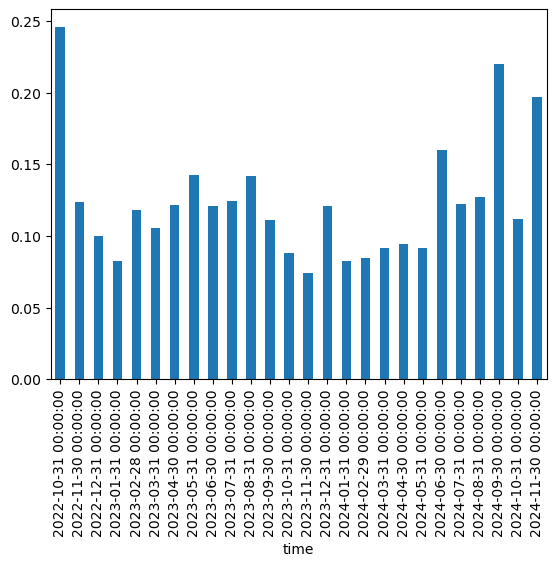

In [140]:
df_result.groupby(pd.Grouper(key='time', freq='M')).target.mean().sort_index().plot.bar()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_41472/539452958.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()


<Axes: xlabel='time'>

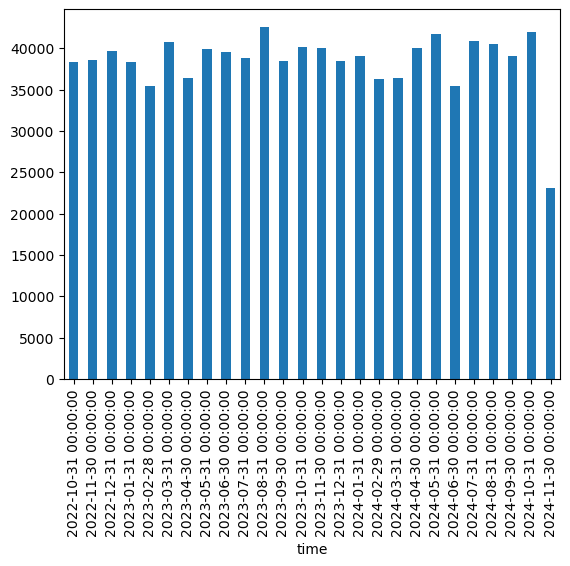

In [139]:
#перепроверка, кол-во точек в каждом месяце
df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()

<Axes: xlabel='ticker'>

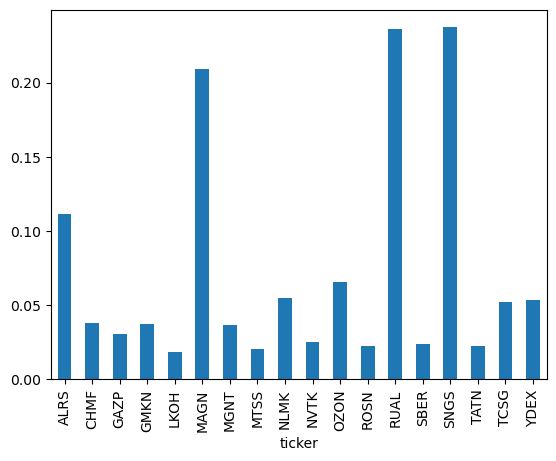

In [94]:
#по акциям
df_result.groupby('ticker').target.mean().sort_index().plot.bar()

<Axes: xlabel='ticker'>

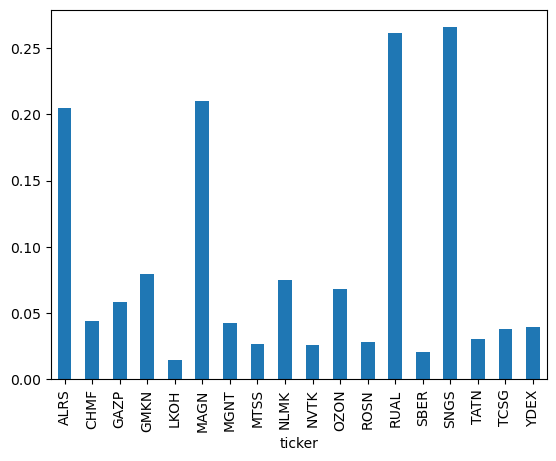

In [95]:
# по компаниям за два последних месяца
mask = df_result['time'] > datetime.datetime(2024, 10, 1)
df_result.loc[mask, :].groupby('ticker').target.mean().sort_index().plot.bar()

# 5.4 Риск менеджмент потери=0.5%, выигрыш=1.5%, ожидание 2 hour

In [96]:
df_result = get_df_target(df, indx, percent_first=0.995, percent_second=1.015, hours_to_wait=2)

100%|█████████████████████████████████████████████████████████████| 1000000/1000000 [03:18<00:00, 5026.21it/s]


In [97]:
#по дню выполнения посмотреть

In [98]:
df_result['result'].value_counts()

result
DNF     643336
LOSE    285295
WIN      71369
Name: count, dtype: int64

In [99]:
df_result['delta_time_days'] = None
mask = df_result['result'] != 'DNF'
df_result.loc[mask, 'delta_time_days'] = np.ceil(df_result.loc[mask, 'delta_time'] / pd.Timedelta(hours=0.5))
df_result.loc[~mask, 'delta_time_days'] = 8

<Axes: xlabel='delta_time_days'>

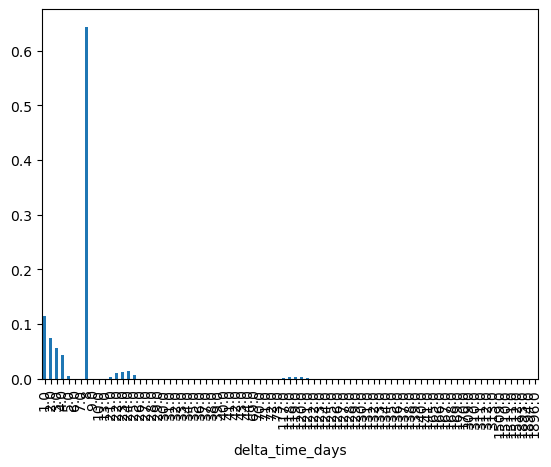

In [100]:
#распределение по длительности
df_result['delta_time_days'].value_counts(normalize=True).sort_index().plot.bar()

In [101]:
#TR по дням ожидания

In [102]:
df_result['target'] = (df_result['result'] == 'WIN').astype(int)

<Axes: xlabel='delta_time_days'>

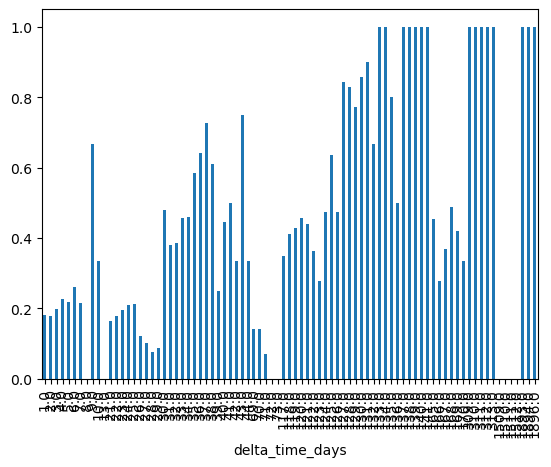

In [103]:
df_result.groupby('delta_time_days').target.mean().sort_index().plot.bar()

In [104]:
#TR во времени

<Axes: xlabel='time'>

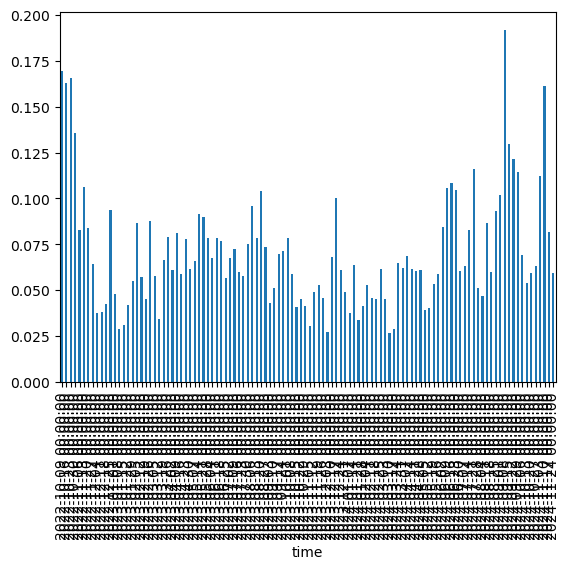

In [106]:
df_result.groupby(pd.Grouper(key='time', freq='W')).target.mean().sort_index().plot.bar()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_41472/539452958.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()


<Axes: xlabel='time'>

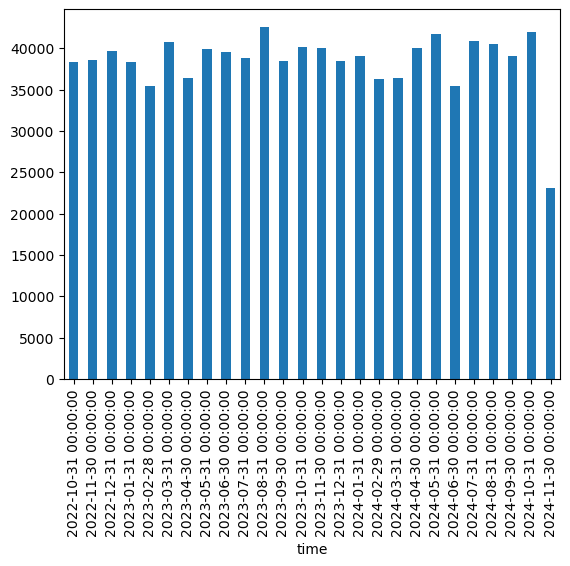

In [107]:
#перепроверка, кол-во точек в каждом месяце
df_result.groupby(pd.Grouper(key='time', freq='M')).target.count().sort_index().plot.bar()

<Axes: xlabel='time'>

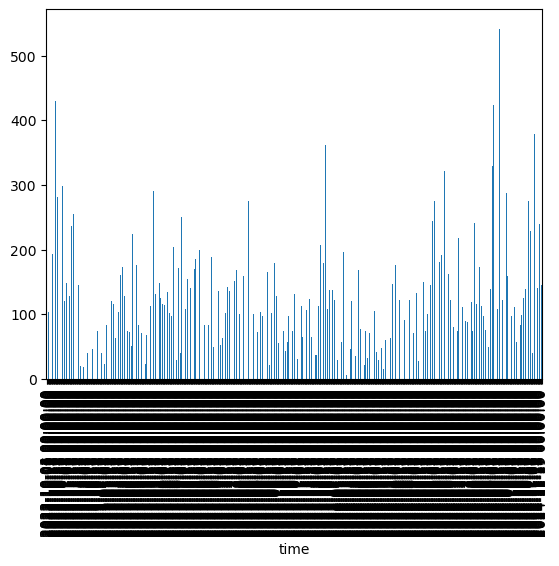

In [108]:
#распределение по дням
df_result.groupby(pd.Grouper(key='time', freq='D')).target.sum().sort_index().plot.bar()

<Axes: xlabel='ticker'>

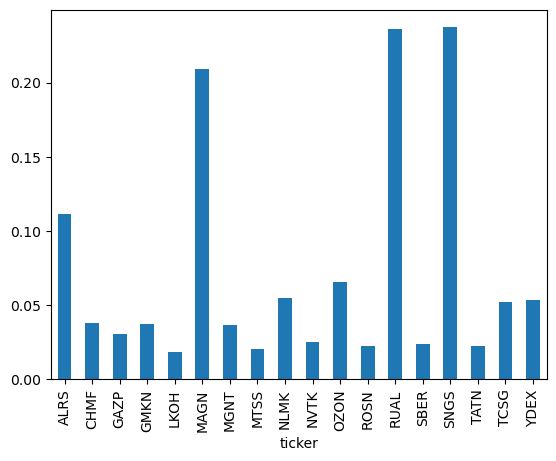

In [109]:
#по акциям
df_result.groupby('ticker').target.mean().sort_index().plot.bar()

<Axes: xlabel='ticker'>

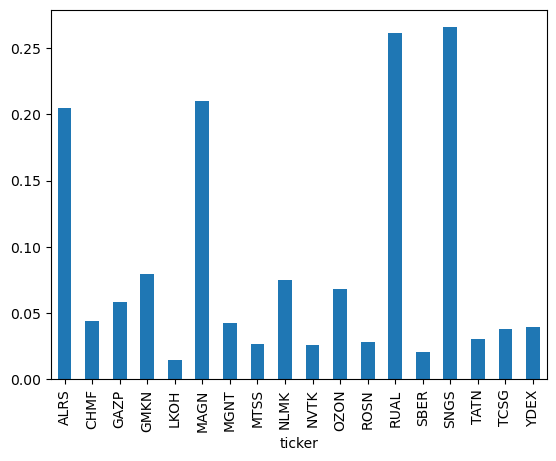

In [110]:
# по компаниям за два последних месяца
mask = df_result['time'] > datetime.datetime(2024, 10, 1)
df_result.loc[mask, :].groupby('ticker').target.mean().sort_index().plot.bar()